# Web Scraping with requests and Beautiful Soup

#### Imports Statements

In [1]:
import requests
from bs4 import BeautifulSoup as bs
from bs4 import Comment
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import random

#### Get URL

In [2]:
url= 'https://www.basketball-reference.com/players/s/simshe01.html'

#### Headers to not overload systems

In [3]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Referer": "http://example.com/previous-page",
    "Cookie": "session_id=your_session_id_here",
    "Connection": "keep-alive",
    "Cache-Control": "max-age=0"
}

#### Get responses from website and return status

In [4]:
response = requests.get(url, headers=headers)
status = response.status_code

#### Return weather you were able to scrap or not

In [5]:
if status == 200:
    page = response.text
    soup = bs(page)
    print("HTML Recieved!")
    
else:
    print(f"Oops! Received status code {status}")

HTML Recieved!


#### Print HTML if obtained

<!DOCTYPE html>
<html class="no-js" data-root="/home/bbr/build" data-version="klecko-" lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="ie=edge" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport"/>
  <link href="https://cdn.ssref.net/req/202511051" rel="dns-prefetch"/>
  <script>
   /* https://docs.osano.com/hc/en-us/articles/22469433444372-Google-Consent-Mode-v2  */
  window.dataLayer = window.dataLayer ||[];
      function gtag(){dataLayer.push(arguments);}
      gtag('consent','default',{
        'ad_storage':'denied',
        'analytics_storage':'denied',
        'ad_user_data':'denied',
        'ad_personalization':'denied',
        'personalization_storage':'denied',
        'functionality_storage':'granted',
        'security_storage':'granted',
        'wait_for_update': 500
      });
      gtag("set", "ads_data_redaction", true);
  </script>
  <script src="https://cmp.osano.com/16CGnCU8UtNhM14s
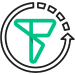
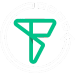

In [6]:
print(soup.prettify())

## Create Pipeline

#### Create function for getting HTML Page

In [7]:
def get_web_page(url):
    # Headers
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "Referer": "http://example.com/previous-page",
        "Cookie": "session_id=your_session_id_here",
        "Connection": "keep-alive",
        "Cache-Control": "max-age=0"
    }
    # Response and status saved
    response = requests.get(url, headers=headers)
    status = response.status_code
    
    # Return if HTML obtained
    if status == 200:
        return response.text
    else:
        print(f"Oops! Received status code {status}")
        return ""

#### Get URLS and pipline list ready

In [8]:
# URl
base = "https://www.basketball-reference.com"
url_start = f"{base}/players/"

# List of Info
pipeline_list = []

#### Get HTML and soup

In [9]:
html = get_web_page(url_start)
soup = bs(html, "html.parser")

#### Find hidden tags within HTML Comments and only keeps URL linked comments *--Used Help from ChatGPT*

In [10]:
# Finds all comments in HTML
comments = soup.find_all(string=lambda text: isinstance(text, Comment))

# Empty List
letter_links = []

# Loop through comments to only keep the ones with URLS and remove the rest
for c in comments:
    if '/players/' in c:
        comment_soup = bs(c, "html.parser")
        for a in comment_soup.select("a[href^='/players/']"):
            href = a.get("href")
            if href and len(href) == 11:
                letter_links.append(base + href)

# Print links found
print(f"Found {len(letter_links)} letter pages.")

Found 25 letter pages.


C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


#### Gather all Player Links

In [11]:
# Empty List
player_links = []

# loop through links and get pages
for letter_url in letter_links:
    page = get_web_page(letter_url)
    soup = bs(page, "html.parser")

    # Get each player table
    for a in soup.select("th[data-stat='player'] a"):
        href = a.get("href")
        # Add url to player link
        if href:
            player_links.append(base + href)
    time.sleep(1)

# print
print(f"Collected {len(player_links)} player profile links.")

Collected 5372 player profile links.


#### Loop through 10 players and scrape each part of their stats

In [12]:
# random 10
random.shuffle(player_links)
# Loop through first 10 players
for i, url in enumerate(player_links[:10]):
    
    # Get the HTML and soup of the player
    html = get_web_page(url)
    soup = bs(html, "html.parser")

    # Get name
    name = soup.find("h1").find("span").text.strip() if soup.find("h1") else "N/A"

    # Get p tags
    position_tag = soup.find("p")
    p_tags = soup.find_all("p")
    position = "N/A"
    weight = None

    # Converts each paragraph into text
    for p in p_tags:
        text = p.get_text(" ", strip=True)
    
        # Look for the Position
        if "Position:" in text:
            # Extract the position value only *got help from chatGPT
            position = (
                text.split("Position:")[1]
                .split("Shoots:")[0]
                .split("▪")[0]
                .strip()
            )
    
        # Look for the Weight
        if "lb" in text:
            spans = p.find_all("span")
            if len(spans) > 1:
                # Extract the weight value only
                weight_text = spans[1].text.strip()
                if "lb" in weight_text:
                    weight = int(weight_text.replace("lb", "").strip())


        # mp_per_g tag
        minute_tags = soup.find_all("td", {"data-stat": "mp_per_g"})
        # extract and convert to float
        minutes_played = [float(tag.text.strip()) for tag in minute_tags if tag.text.strip()]

        # pts_per_g tag
        ppg_tags = soup.find_all("td", {"data-stat": "pts_per_g"})
        # extract and convert to float
        points_per_game = [float(tag.text.strip()) for tag in ppg_tags if tag.text.strip()]
          
        # fta_per_g tag
        fta_tags = soup.find_all("td", {"data-stat": "fta_per_g"})
        # Create empty list
        free_throws = []
        # Loop throuhg the tag and add values to list * got help from chatGPT
        for tag in fta_tags:
            text = tag.text.strip()
            if text:  # skip empty cells
                try:
                    free_throws.append(float(text))
                except ValueError:
                    pass  # ignore non-numeric text
        # if no values resort to 0
        if not free_throws:
            free_throws = [0]

        # blk_per_g tag
        blk_tags = soup.find_all("td", {"data-stat": "blk_per_g"})
        # extract and convert to float *got help from chatGPT
        blocks = float(blk_tags[-1].text.strip()) if blk_tags and blk_tags[-1].text.strip() else 0
        
        # games total
        total_games = 0
        games_label = soup.find("span", {"class": "poptip", "data-tip": "Games"})
        if games_label:
            # find the p tag and get the total game
            p_tag = games_label.find_next("p").find_next("p")
            if p_tag and p_tag.text.strip().isdigit():
                total_games = int(p_tag.text.strip())

        # Create a big dictionary for each player with their corresponding stats
        player_dict = {
        "name": name,
        "position": position,
        "weight": weight,
        "minutes played": minutes_played,
        "points": points_per_game,
        "free_throws": free_throws,
        "blocks": blocks,
        "total_games": total_games
        }
        
    # Add to pipeline list
    pipeline_list.append(player_dict)
    if i % 1 == 0:
        print(f"Processed {i+1}/{len(player_links)} players...")
    
    # sleep between requests
    time.sleep(2)
print(f"\nTotal players scraped: {len(pipeline_list)}")
print(pipeline_list[:10])

Processed 1/5372 players...
Processed 2/5372 players...
Processed 3/5372 players...
Processed 4/5372 players...
Processed 5/5372 players...
Processed 6/5372 players...
Processed 7/5372 players...
Processed 8/5372 players...
Processed 9/5372 players...
Processed 10/5372 players...

Total players scraped: 10
[{'name': 'John Brown', 'position': 'Small Forward and Power Forward', 'weight': 220, 'minutes played': [22.3, 27.2, 23.4, 18.2, 21.3, 16.4, 12.0, 6.0, 12.9, 20.8, 21.8, 16.4, 6.0, 3.0, 11.6, 9.1], 'points': [9.3, 11.2, 7.9, 5.7, 7.3, 5.0, 3.5, 1.0, 3.9, 7.4, 8.0, 5.0, 1.0, 0.0, 2.0, 1.4], 'free_throws': [2.8, 3.4, 2.8, 1.9, 2.7, 1.3, 1.5, 1.0, 1.6, 2.4, 2.6, 1.3, 1.0, 0.0, 0.4, 0.3], 'blocks': 0.1, 'total_games': 486}, {'name': 'George McCloud', 'position': 'Small Forward', 'weight': 225, 'minutes played': [9.4, 14.5, 17.5, 19.2, 19.1, 36.0, 23.3, 29.4, 12.4, 19.3, 25.9, 27.2, 26.4, 26.5, 22.8, 15.7, 26.7, 30.0, 22.1, 12.4, 4.0, 26.5, 19.8, 31.5, 26.7, 24.4, 19.4, 29.4], 'points': [

#### Start to move data to pandas df

In [13]:
# Convert player dictionaries to df
df = pd.DataFrame(pipeline_list)

# standardize column
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

#### Get averages for mp p ft and b

In [14]:
# change col names
for col, new_col in [
    ("minutes_played", "avg_minutes"),
    ("points", "avg_points"),
    ("free_throws", "avg_free_throws"),
    ("blocks", "avg_blocks")]:
    # get average * help from chatGPT
    if col in df.columns:
        df[new_col] = df[col].apply(
            # If value is a list and not empty, calculate the average
            lambda x: round(sum(x) / len(x), 1) if isinstance(x, list) and len(x) > 0
            # If value is a single number, convert it to float
            else round(float(x), 1) if x not in [None, 'NaN', ''] and not isinstance(x, list) else 0
        )
    # if nothing return 0
    else:
        df[new_col] = 0

#### Drop the old columns

In [15]:
# drop columns
for col in ["minutes_played", "points", "free_throws", "blocks"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

print("Taking data on these 15 players:")
df

Taking data on these 15 players:


,name,position,weight,total_games,avg_minutes,avg_points,avg_free_throws,avg_blocks
0,John Brown,Small Forward and Power Forward,220,486,15.5,5.0,1.7,0.1
1,George McCloud,Small Forward,225,766,22.1,9.0,1.7,0.1
2,Al Butler,Point Guard,175,234,18.7,8.5,2.0,0.0
3,Bob Elliott,Power Forward and Center,225,141,17.0,7.2,3.1,0.2
4,James Johnson,"Power Forward, Small Forward, and Center",240,786,16.1,6.0,1.5,0.0
5,Ken McBride,Shooting Guard,190,12,20.8,9.8,2.4,0.0
6,Nikola JoviÄ,Power Forward,209,120,17.9,7.4,1.4,0.3
7,Devin Vassell,Shooting Guard and Small Forward,200,316,28.6,14.3,1.9,0.4
8,Alex Blackwell,Small Forward,250,27,4.0,1.3,0.3,0.1
9,Kenny Payne,Small Forward,195,144,7.0,3.4,0.5,0.0


#### Seaborn Styles

In [16]:
sns.set(style="whitegrid")

### Question 1: Who has the Highest Free Throw Attempts per Game (Based on list)
#### Create seaborn barplot

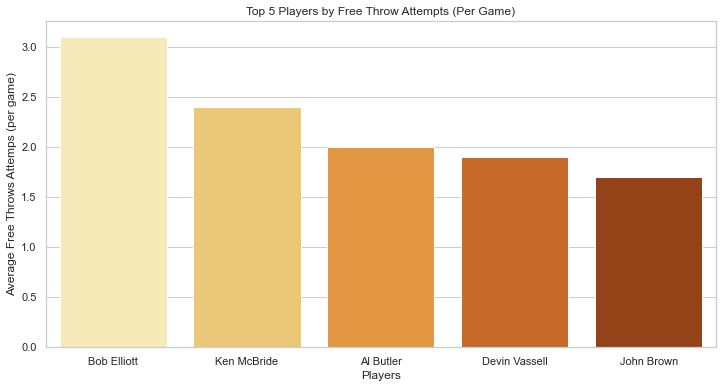

In [17]:
# Get top 5
top_5_players = df.nlargest(5, 'avg_free_throws')
# Create plot
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='avg_free_throws', data=top_5_players, palette="YlOrBr")
# Change title and axis
plt.title("Top 5 Players by Free Throw Attempts (Per Game)")
plt.xlabel("Players")
plt.ylabel("Average Free Throws Attemps (per game)")
plt.show()

#### Conclusion: Bob Elliott has the highest free throw attempts per game

### Question 2: Who has the Highest Minutes Played per Game (Based on list)
#### Create seaborn barplot

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 135 (\x87) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


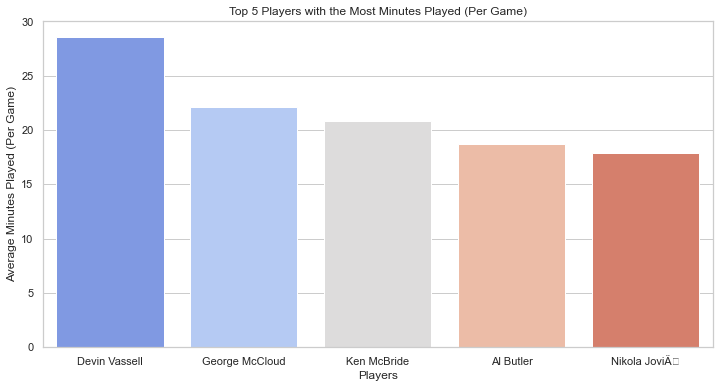

In [18]:
# Get top 5
top_5_minutes = df.nlargest(5, 'avg_minutes')
# Create Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='avg_minutes', data=top_5_minutes, palette="coolwarm")
# Change title and axis
plt.title("Top 5 Players with the Most Minutes Played (Per Game)")
plt.xlabel("Players")
plt.ylabel("Average Minutes Played (Per Game)")
plt.show()

#### Conclusion:Devin Vassell has the highest minutes played per game

### Question 3: Who has the Highest Points per Game (Based on list)
#### Create seaborn barplot

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 135 (\x87) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


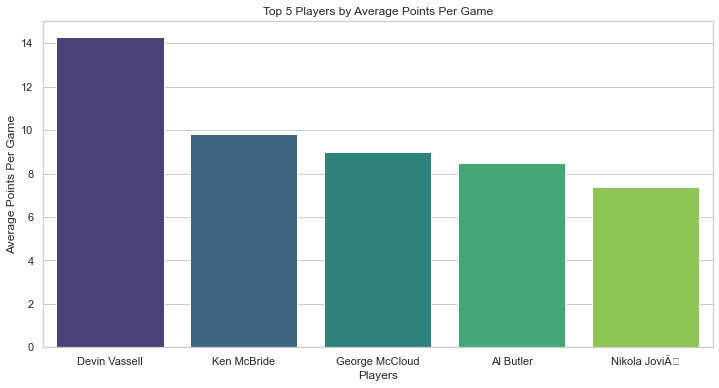

In [19]:
# Get top 5
top_5_points = df.nlargest(5, 'avg_points')
# Create plot
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='avg_points', data=top_5_points, palette="viridis")
# Change title and axis
plt.title("Top 5 Players by Average Points Per Game")
plt.xlabel("Players")
plt.ylabel("Average Points Per Game")
plt.show()

#### Conclusion:Devin Vassell has the highest points per game

### Question 4: Who has the Highest Blocks per Game (Based on list)
#### Create seaborn barplot

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 135 (\x87) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


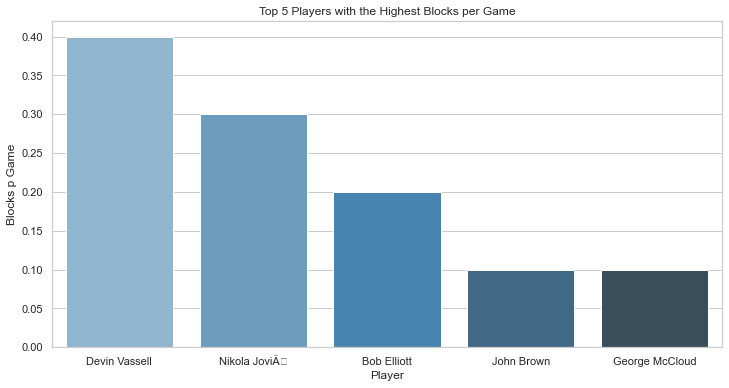

In [20]:
# Get top 5
top_5_blocks = df.nlargest(5, 'avg_blocks')
# Create plot
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='avg_blocks', data=top_5_blocks, palette="Blues_d")
# Change title and axis
plt.title("Top 5 Players with the Highest Blocks per Game")
plt.xlabel("Player")
plt.ylabel("Blocks p Game")
plt.show()

#### Conclusion: Devin Vassell has the highest blocks per game

### Question 5: What are the Total Games Played by Each Player in descending order (Based on list)
#### Create seaborn barplot

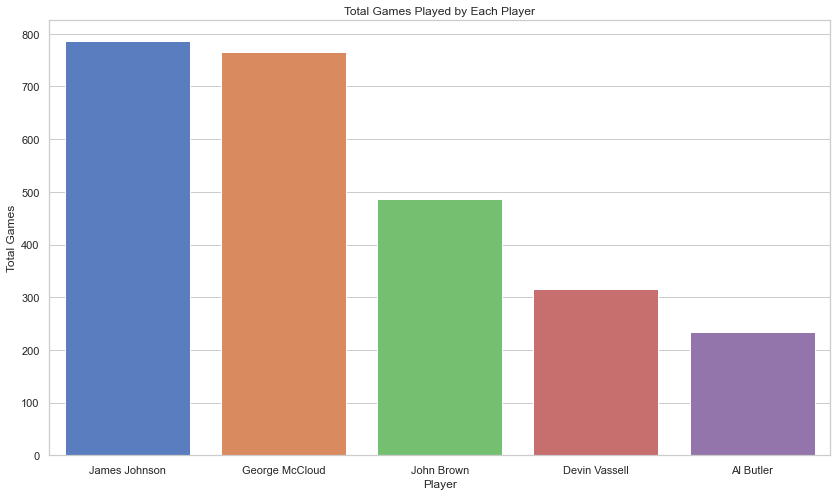

In [21]:
# Get top 5
top_5_games = df.nlargest(5, 'total_games')
# Create plot
plt.figure(figsize=(14, 8))
sns.barplot(x='name', y='total_games', data=top_5_games, palette="muted")
# Change title and axis
plt.title("Total Games Played by Each Player")
plt.xlabel("Player")
plt.ylabel("Total Games")
plt.show()


#### Conclusion: James Johnson has the highest total games played